# UKKO - Transformer model for tabular longitudonal data 

Author: Eric Fey (eric.fey@hus.fi)
First version: 2025-03-01

Usage:
1. Install hatchling 
  ```bash
  pip install hatchling
  ```
2. Install ukko package in development (editable) mode:
  ```bash
  pip install -e .
  ```
3. Go :smiley:

In [1]:
!pip install -e .

Obtaining file:///C:/Users/ericf/Github/ukko
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for ukko (pyproject.toml): started
  Building editable for ukko (pyproject.toml): finished with status 'done'
  Created wheel for ukko: filename=ukko-0.1.0-py3-none-any.whl size=1091 sha256=03de1317c853b6ca16462018311d1ea0957dc6410713d06f45e2c00ac4bffdc6
  Stored in directory: C:\Users\ericf\AppData\Local\Temp\pip-ephem-wheel-cache

In [1]:
# attention model with residual connectoin
import torch
import torch.nn as nn
import math
import ukko 

In [2]:
# Test ukko installatin and model
%run ./tests/tests_core.py
test_model()

Input shape: torch.Size([2, 3, 5])
Output shape: torch.Size([2, 3])
Feature attention weights shape: torch.Size([10, 5, 3, 3])
Time attention weights shape: torch.Size([6, 5, 5, 5])


(DualAttentionModel(
   (input_projection): Linear(in_features=1, out_features=10, bias=True)
   (pos_encoder): PositionalEncoding()
   (feature_attention): MultiHeadAttention(
     (W_q): Linear(in_features=10, out_features=10, bias=True)
     (W_k): Linear(in_features=10, out_features=10, bias=True)
     (W_v): Linear(in_features=10, out_features=10, bias=True)
     (W_o): Linear(in_features=10, out_features=10, bias=True)
     (dropout): Dropout(p=0.1, inplace=False)
   )
   (feature_norm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
   (feature_ff): FeedForward(
     (linear1): Linear(in_features=10, out_features=2048, bias=True)
     (linear2): Linear(in_features=2048, out_features=10, bias=True)
     (dropout): Dropout(p=0.1, inplace=False)
     (activation): ReLU()
   )
   (feature_ff_norm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
   (time_attention): MultiHeadAttention(
     (W_q): Linear(in_features=10, out_features=10, bias=True)
     (W_k): Linear(in_fe

## Test data sine wave

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from datetime import datetime
import ukko

class SineWaveDataset(Dataset):
    def __init__(self, n_samples, n_features, sequence_length, prediction_length=5,
                 base_freq=0.1, noise_level=0.2, seed=42):
        """
        Creates sine wave dataset with different phases and amplitudes for each feature

        Args:
            n_samples: Number of samples in dataset
            n_features: Number of features
            sequence_length: Length of input sequence
            prediction_length: Length of sequence to predict
            base_freq: Base frequency of sine waves
            noise_level: Standard deviation of Gaussian noise
        """
        np.random.seed(seed)
        torch.manual_seed(seed)

        self.sequence_length = sequence_length
        self.prediction_length = prediction_length

        # Create time points
        t = np.linspace(0, (sequence_length + prediction_length) * 2 * np.pi,
                       sequence_length + prediction_length)

        # Generate data for each sample
        data = []
        groundtruth = []
        for _ in range(n_samples):
            sample = []
            groundtruthsample = []
            for f in range(n_features):
                # Random phase and amplitude for each feature
                phase = np.random.uniform(0, 2 * np.pi)
                amplitude = np.random.uniform(0.5, 2.0)

                # Generate sine wave with noise
                sine_wave = amplitude * np.sin(base_freq * t + phase)
                noise = np.random.normal(0, noise_level, len(t))
                feature_data = sine_wave + noise

                sample.append(feature_data)
                groundtruthsample.append(sine_wave)
            data.append(sample)
            groundtruth.append(groundtruthsample)

        # Convert to torch tensors
        self.data = torch.FloatTensor(data)  # [n_samples, n_features, sequence_length + prediction_length]
        self.groundtruth = torch.FloatTensor(groundtruth)

    def __len__(self):
        return len(self.data)

    # data with noise
    def __getitem__(self, idx):
        x = self.data[idx, :, :self.sequence_length]
        #y = self.data[idx, :, self.sequence_length:self.sequence_length + self.prediction_length]
        y = self.data[idx, :, self.sequence_length + self.prediction_length -1]
        return x, y

    # groundtruth data:
    def __getgtitem__(self, idx):
        x = self.groundtruth[idx, :, :self.sequence_length]
        y = self.groundtruth[idx, :, self.sequence_length:self.sequence_length + self.prediction_length]
        return x, y

def plot_example(dataset, sample_idx=0, feature_idx=0):
    """Plot an example from the dataset with markers"""
    x, y = dataset[sample_idx]
    xgt, ygt = dataset.__getgtitem__(sample_idx)

    plt.figure(figsize=(12, 6))

    # Plot data sample with noise
    # Plot input sequence with markers
    plt.plot(range(len(x[feature_idx])), x[feature_idx],
             'o', label='Input sequence', color='blue',
             markersize=4, markerfacecolor='white', markeredgewidth=1)

    # Plot target sequence with different markers
    #plt.plot(range(len(x[feature_idx]), len(x[feature_idx]) + len(y[feature_idx])),
    #         y[feature_idx], 's', label='Target sequence', color='red',
    #         markersize=6, markerfacecolor='white', markeredgewidth=1)
    plt.plot(len(x[feature_idx]) + 5 - 1,
             y[feature_idx], 's', label='Target sequence', color='red',
             markersize=6, markerfacecolor='white', markeredgewidth=1)

    # Plot groundtruth wave
    xygt = torch.cat((xgt, ygt), dim=1)[feature_idx]
    plt.plot(range(len(xygt)), xygt,
             '-', label='Ground truth', color='gray',
             markersize=0, markerfacecolor='white', markeredgewidth=1)


    plt.title(f'Example Sine Wave - Feature {feature_idx}')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    # Add timestamp and user info
    timestamp = "2025-03-01 14:35:23"
    user = "eric-fey-hus"
    plt.text(0.02, 0.02, f'Generated: {timestamp}\nUser: {user}',
             transform=plt.gca().transAxes, fontsize=8,
             bbox=dict(facecolor='white', alpha=0.8))

    plt.show()

def create_data_loaders(batch_size=32, n_samples=1000, n_features=15,
                       sequence_length=100, prediction_length=5):
    """Create train, validation, and test data loaders"""

    # Create datasets
    train_dataset = SineWaveDataset(n_samples, n_features, sequence_length, prediction_length)
    val_dataset = SineWaveDataset(n_samples//5, n_features, sequence_length, prediction_length, seed=43)
    test_dataset = SineWaveDataset(n_samples//5, n_features, sequence_length, prediction_length, seed=44)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

def test_model_with_sine_data():
    # Parameters
    batch_size = 32
    n_samples = 1000
    n_features = 3
    sequence_length = 32
    prediction_length = 5

    # Create data loaders
    train_loader, val_loader, test_loader = create_data_loaders(
        batch_size=batch_size,
        n_samples=n_samples,
        n_features=n_features,
        sequence_length=sequence_length,
        prediction_length=prediction_length
    )

    # # Initialize model
    # model = ukko.DualAttentionModel(
    #     n_features=n_features,
    #     time_steps=sequence_length,
    #     d_model=128,
    #     n_heads=8,
    #     dropout=0.1
    # )
    model = []


    # Plot example
    dataset = SineWaveDataset(n_samples, n_features, sequence_length, prediction_length)
    plot_example(dataset, sample_idx=1)

    return model, train_loader, val_loader, test_loader

#if __name__ == "__main__":
#model, train_loader, val_loader, test_loader = test_model_with_sine_data()

In [2]:
for x, y in val_loader:
  print(x.shape)
  print(y.shape)

NameError: name 'val_loader' is not defined

In [ ]:
dataset = SineWaveDataset(n_samples=5, n_features=3, sequence_length=5, prediction_length=2)
print(dataset[0][0])
print(dataset[0][1])
print(torch.cat(dataset[0],dim=1))
type(torch.cat(dataset[0],dim=1))

tensor([[ 1.4306,  0.2587, -1.2312, -1.9249, -1.4604],
        [ 0.7593,  0.7636,  0.2026, -0.3265, -0.6790],
        [ 1.1595,  0.5464, -0.1605, -0.9601, -1.1024]])
tensor([[-0.4271,  0.8225],
        [-0.8729, -0.4927],
        [-0.7288, -0.1669]])
tensor([[ 1.4306,  0.2587, -1.2312, -1.9249, -1.4604, -0.4271,  0.8225],
        [ 0.7593,  0.7636,  0.2026, -0.3265, -0.6790, -0.8729, -0.4927],
        [ 1.1595,  0.5464, -0.1605, -0.9601, -1.1024, -0.7288, -0.1669]])


torch.Tensor

Input shape: torch.Size([32, 3, 32])
Target shape: torch.Size([32, 3])
Output shape: torch.Size([32, 3])


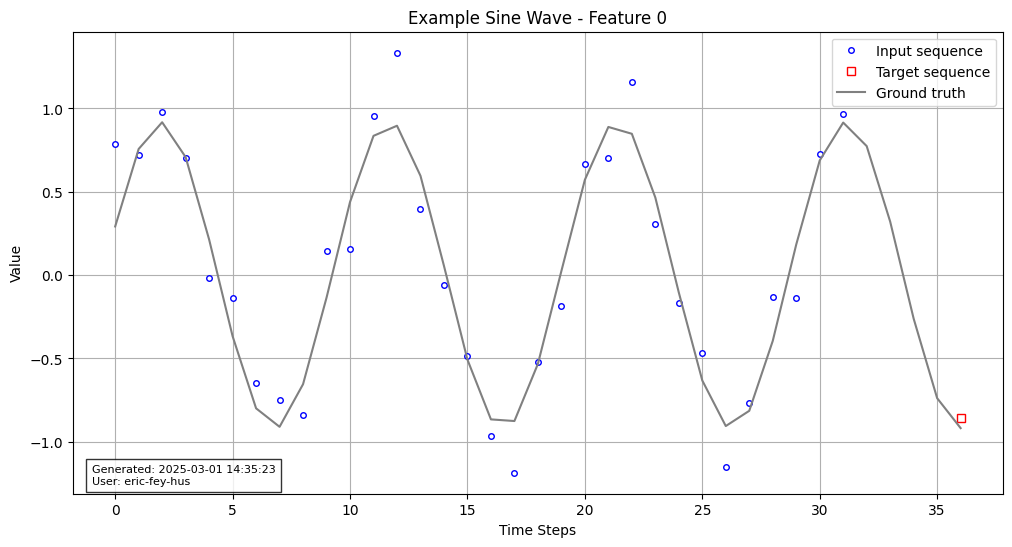

Epoch 1/50
Train Loss: 2.4105
Val Loss: 0.9751
Epoch 2/50
Train Loss: 0.9538
Val Loss: 0.9879
Epoch 3/50
Train Loss: 0.9641
Val Loss: 0.9533
Epoch 4/50
Train Loss: 0.9276
Val Loss: 0.8562
Epoch 5/50
Train Loss: 0.3630
Val Loss: 0.1623
Epoch 6/50
Train Loss: 0.1002
Val Loss: 0.0661
Epoch 7/50
Train Loss: 0.0687
Val Loss: 0.0751
Epoch 8/50
Train Loss: 0.0670
Val Loss: 0.0662
Epoch 9/50
Train Loss: 0.0629
Val Loss: 0.0566
Epoch 10/50
Train Loss: 0.0634
Val Loss: 0.0571
Epoch 11/50
Train Loss: 0.0668
Val Loss: 0.0527
Epoch 12/50
Train Loss: 0.0589
Val Loss: 0.0647
Epoch 13/50
Train Loss: 0.0602
Val Loss: 0.0673
Epoch 14/50
Train Loss: 0.0564
Val Loss: 0.0562
Epoch 15/50
Train Loss: 0.0570
Val Loss: 0.0489
Epoch 16/50
Train Loss: 0.0542
Val Loss: 0.0573
Epoch 17/50
Train Loss: 0.0568
Val Loss: 0.0575
Epoch 18/50
Train Loss: 0.0552
Val Loss: 0.0723
Epoch 19/50
Train Loss: 0.0539
Val Loss: 0.0479
Epoch 20/50
Train Loss: 0.0561
Val Loss: 0.0642
Epoch 21/50
Train Loss: 0.0518
Val Loss: 0.0552
E

In [ ]:
def train_sine_model(model, train_loader, val_loader, epochs=50, lr=0.001, device='cuda'):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            output, _, _ = model(x)
            #loss = criterion(output, y[:, :, 0])  # Compare with first time step of prediction
            loss = criterion(output, y)  # y is only one timepoint 5 or 4 steps ahead

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output, _, _ = model(x)
                #val_loss += criterion(output, y[:, :, 0]).item()
                val_loss += criterion(output, y).item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_sine_model.pt')

# Train the model
model, train_loader, val_loader, test_loader = test_model_with_sine_data()
train_sine_model(model, train_loader, val_loader)

<ipython-input-18-37422b1e4acf>:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_sine_model.pt'))


Loaded best model weights successfully!
Test Set Metrics:
Average MSE: 0.0480
Average MAE: 0.1757
RMSE: 0.2192


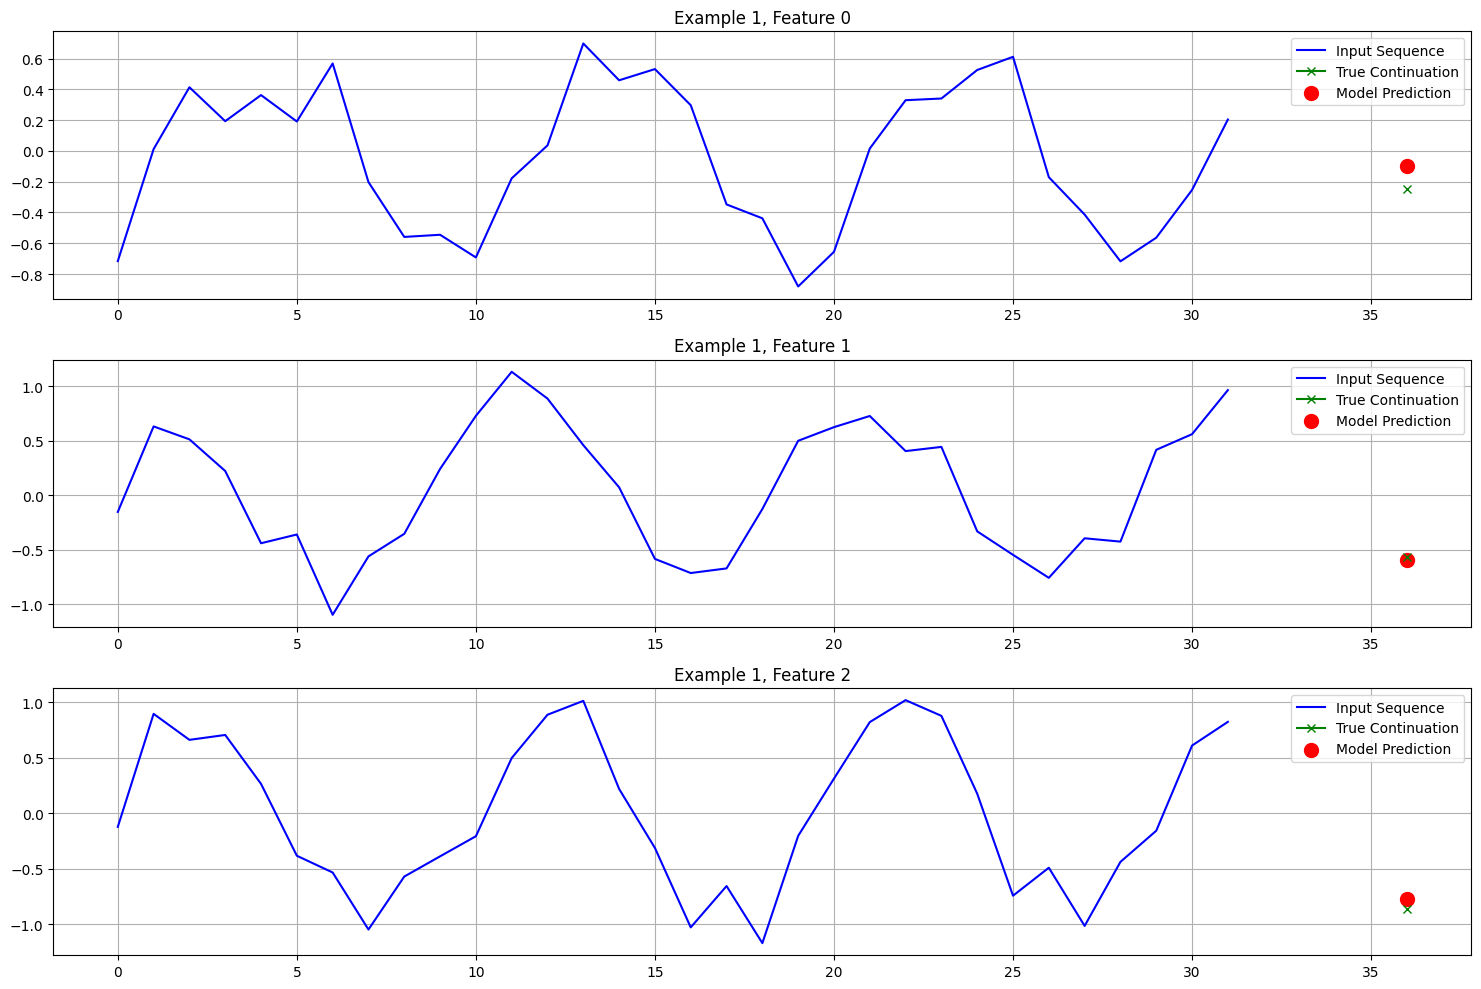

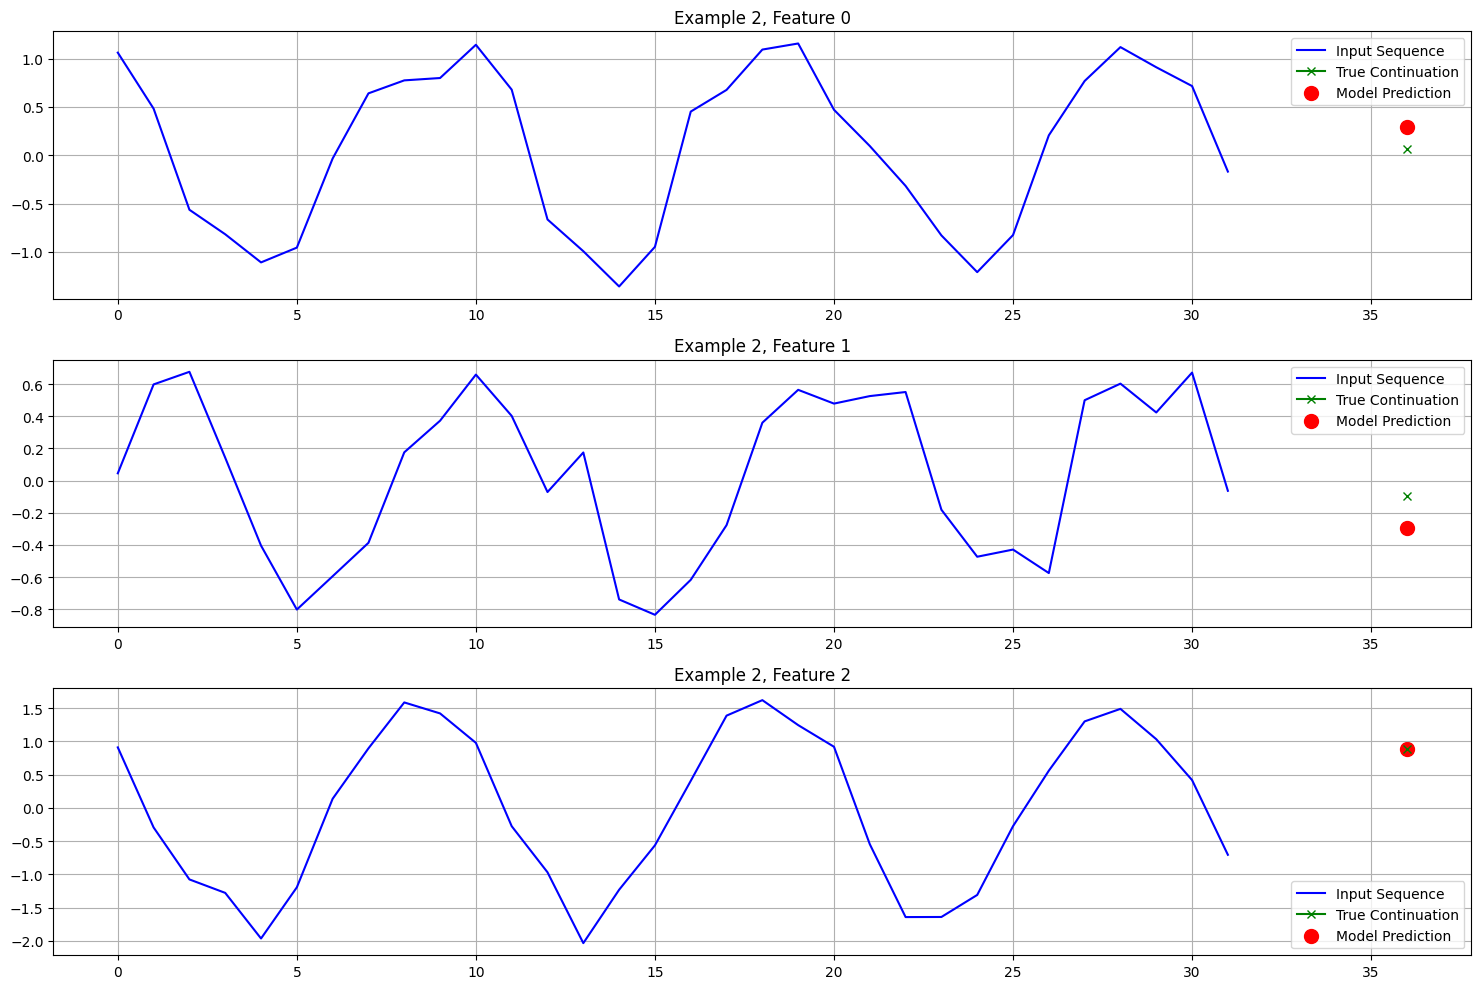

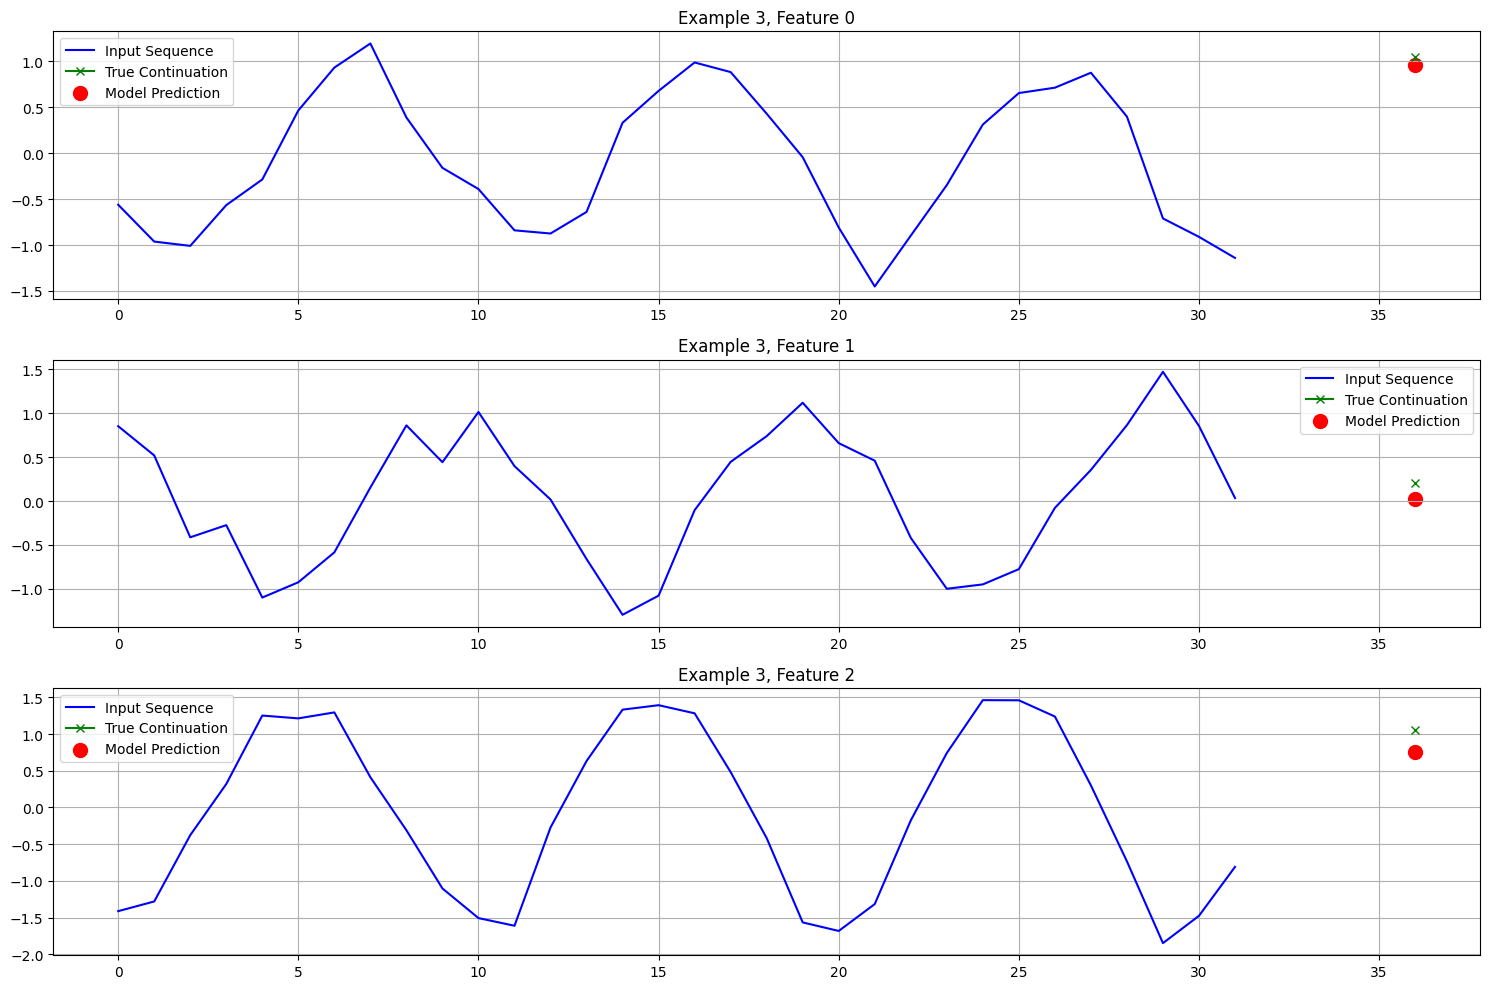

Data: (32, 3)
Predictions: (32, 3)


<ipython-input-18-37422b1e4acf>:58: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(predictions[:,col], y[:,col],


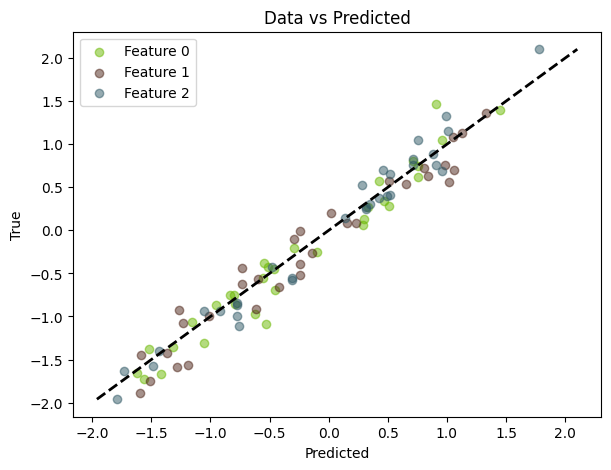

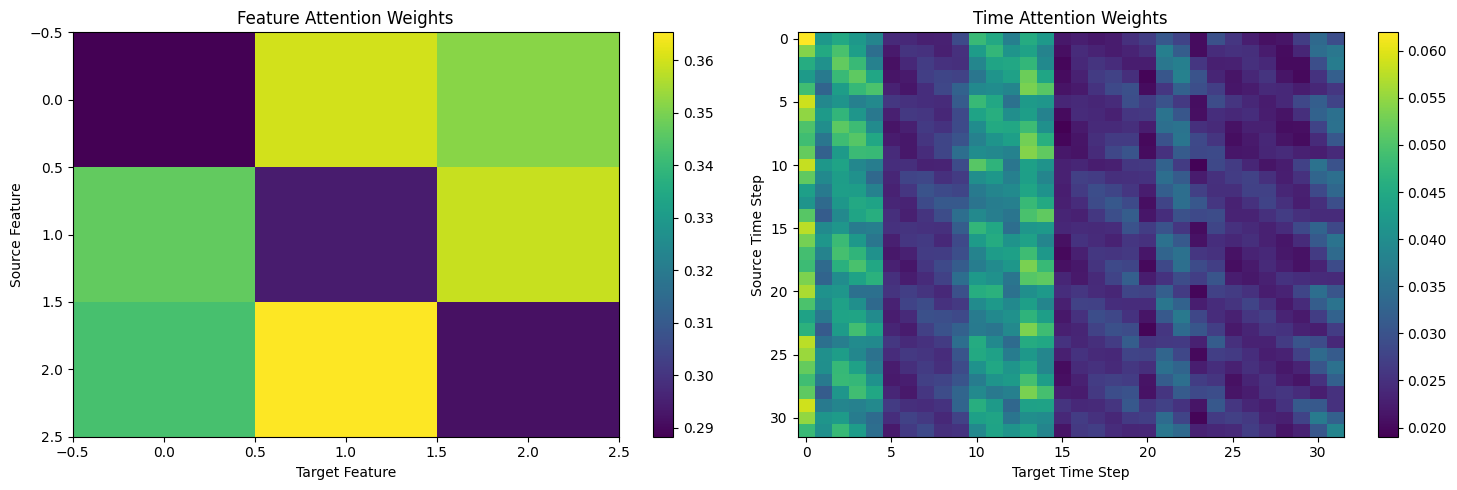

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

def visualize_predictions(model, test_loader, device='cuda', num_examples=3):
    model.eval()

    # Get some test examples
    x, y = next(iter(test_loader))
    x, y = x.to(device), y.to(device)

    # Get predictions
    with torch.no_grad():
        predictions, feat_attn, time_attn = model(x)
        predictions = predictions.cpu().numpy()
        x = x.cpu().numpy()
        y = y.cpu().numpy()

    # Plot multiple features for a few examples
    for example_idx in range(min(num_examples, x.shape[0])):
        plt.figure(figsize=(15, 10))

        # Plot 3 different features
        for i, feature_idx in enumerate([0,1,2]):#([0, 7, 14]):  # Beginning, middle, and end features
            plt.subplot(3, 1, i+1)

            # Plot input sequence
            time_input = np.arange(x.shape[2])
            plt.plot(time_input, x[example_idx, feature_idx],
                    label='Input Sequence', color='blue')

            # Plot true continuation
            #time_target = np.arange(x.shape[2], x.shape[2] + y.shape[2])
            time_target = [x.shape[2] + 5 - 1]
            plt.plot(time_target, y[example_idx, feature_idx], "x-",
                    label='True Continuation', color='green')

            # Plot prediction
            plt.scatter(time_target[0], predictions[example_idx, feature_idx],
                       color='red', label='Model Prediction', s=100)

            plt.title(f'Example {example_idx + 1}, Feature {feature_idx}')
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.show()

    # Plot data vs predicted & groundtruth vs predicted
    plt.figure(figsize=(15, 5))
    # data vs predicted
    plt.subplot(1, 2, 1)
    print(f"Data: {y.shape}")
    print(f"Predictions: {predictions.shape}")
    np.random.seed(1)
    for col in range(y.shape[1]):
      plt.scatter(predictions[:,col], y[:,col],
                  c=np.random.rand(3,), label=f'Feature {col}', alpha=0.5)
    # Add perfect line
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Data vs Predicted')
    plt.legend()

    # Visualize attention weights
    plt.figure(figsize=(15, 5))

    # Feature attention weights
    plt.subplot(1, 2, 1)
    feat_attn_avg = feat_attn.mean(dim=(0, 1)).cpu().numpy()
    plt.imshow(feat_attn_avg, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Feature Attention Weights')
    plt.xlabel('Target Feature')
    plt.ylabel('Source Feature')

    # Time attention weights
    plt.subplot(1, 2, 2)
    time_attn_avg = time_attn.mean(dim=(0, 1)).cpu().numpy()
    plt.imshow(time_attn_avg, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title('Time Attention Weights')
    plt.xlabel('Target Time Step')
    plt.ylabel('Source Time Step')

    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    criterion = torch.nn.MSELoss()
    total_mse = 0
    total_mae = 0
    num_batches = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            predictions, _, _ = model(x)

            # Calculate MSE and MAE
            #mse = criterion(predictions, y[:, :, 0])
            #mae = torch.abs(predictions - y[:, :, 0]).mean()
            mse = criterion(predictions, y)
            mae = torch.abs(predictions - y).mean()

            total_mse += mse.item()
            total_mae += mae.item()
            num_batches += 1

    avg_mse = total_mse / num_batches
    avg_mae = total_mae / num_batches

    print(f"Test Set Metrics:")
    print(f"Average MSE: {avg_mse:.4f}")
    print(f"Average MAE: {avg_mae:.4f}")
    print(f"RMSE: {np.sqrt(avg_mse):.4f}")

    return avg_mse, avg_mae

def main():
    # Parameters
    batch_size = 32
    n_samples = 1000
    n_features = 3
    sequence_length = 32
    prediction_length = 5

    # Create data loaders
    train_loader, val_loader, test_loader = create_data_loaders(
        batch_size=batch_size,
        n_samples=n_samples,
        n_features=n_features,
        sequence_length=sequence_length,
        prediction_length=prediction_length
    )

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DualAttentionModel(
        n_features=n_features,
        time_steps=sequence_length,
        d_model=128,
        n_heads=8,
        dropout=0.1
    ).to(device)

    # Load best model weights
    try:
        model.load_state_dict(torch.load('best_sine_model.pt'))
        print("Loaded best model weights successfully!")
    except:
        print("No saved model found. Please train the model first.")
        return

    # Evaluate model
    mse, mae = evaluate_model(model, test_loader, device)

    # Visualize results
    visualize_predictions(model, test_loader, device)

    # Save a timestamp of when these results were generated
    timestamp = "2025-03-01 10:01:16"  # Using the provided timestamp
    user = "eric-fey-hus"

    # Save results to a file
    with open('model_results.txt', 'w') as f:
        f.write(f"Results generated on: {timestamp}\n")
        f.write(f"Generated by user: {user}\n")
        f.write(f"Model Performance Metrics:\n")
        f.write(f"MSE: {mse:.4f}\n")
        f.write(f"MAE: {mae:.4f}\n")
        f.write(f"RMSE: {np.sqrt(mse):.4f}\n")

#if __name__ == "__main__":
main()

# Classifier

Starting training...
  Batch 0 - Data shape: torch.Size([32, 10, 50]), Target shape: torch.Size([32, 10])
Epoch 1/3, Loss: 1.1737
  Batch 0 - Data shape: torch.Size([32, 10, 50]), Target shape: torch.Size([32, 10])
Epoch 2/3, Loss: 1.1473
  Batch 0 - Data shape: torch.Size([32, 10, 50]), Target shape: torch.Size([32, 10])
Epoch 3/3, Loss: 1.1008
Training complete!


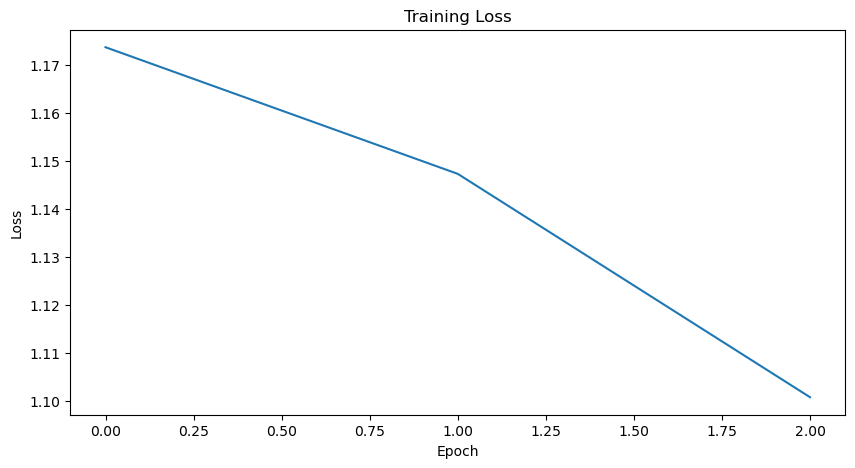

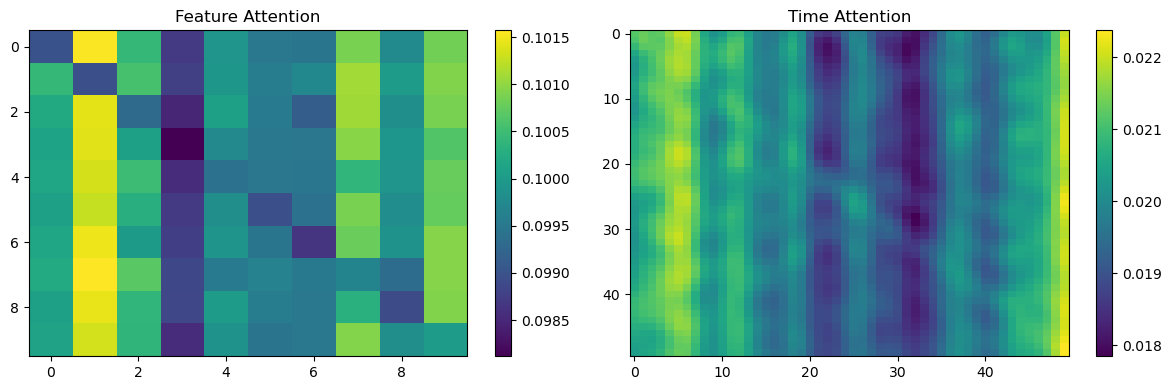

In [17]:
# First reload modules to ensure latest changes
import importlib
import ukko.core
import ukko.data
importlib.reload(ukko.core)
importlib.reload(ukko.data)

# Import test function 
from ukko.core import DualAttentionClassifier, visualize_predictions
from ukko.data import SineWaveDataset

# Run the test
#from tests.test_dual_attention_classifier import test_dual_attention_classifier
#test_dual_attention_classifier()

%run ./tests/test_dual_attention_classifier.py
model, train_losses, plt1, plt2 = test_dual_attention_classifier(n_epochs = 3)